# Finding Elo Kaggle Competition
### Predict a chess player's FIDE Elo rating from one game

Our imports and constant values

In [130]:
import math
import numpy as np # linear algebra
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import chess.pgn


GAME_DATA_FILE = "data.pgn"
MOVE_EVAL_FILE = "stockfish.csv"

game_moves_scores_df = pd.read_csv(MOVE_EVAL_FILE)

REGULAR_LENGTH = 25000
SHORT_LENGTH = 15

TRAINING_SET_LENGTH = REGULAR_LENGTH
TEST_SET_LENGTH = REGULAR_LENGTH

Totaling the sum of move scores of each game and adding it to a list

In [131]:
# calculates the win % chance of each move
def calculate_win(centipawns):
    winning_chances = 2 / (1 + math.exp(-0.00368208 * centipawns)) - 1
    win_percentage = 50 + 50 * (winning_chances)
    return win_percentage

# calculates the accuracy % chance of each move
def calculate_accuracy(win_percent_before, win_percent_after):
    if win_percent_after >= win_percent_before:
        return 100
    else:
        win_diff = win_percent_before - win_percent_after
        accuracy_percentage =  103.1668100711649 * math.exp(-0.04354415386753951 * win_diff) - 3.166924740191411
        accuracy_percentage += 1
        return max(min(accuracy_percentage, 100), 0)

# takes in the string of game moves and extracts and parses the data into different lists
def get_move_analysis_list(moves_list):
    scores = []
    deltas = []
    win_percentages = []
    accuracy_percentages = []
    for i in range(len(moves_list)):
        # raw score
        if moves_list[i] != "NA":
            score = int(moves_list[i])
            scores.append(score)

        # raw score delta
        if i < len(moves_list) - 1:
            delta = 0
            if (moves_list[i+1] != "NA"):
                next_score = int(moves_list[i+1])
                delta = next_score - score
            deltas.append(delta)

        # win percentage each move
        win_percentage = calculate_win(score)
        win_percentages.append(win_percentage)

        # accuracy percentage each move
        if i > 0:
            accuracy_percentage = calculate_accuracy(win_percentages[i - 1], win_percentage)
            accuracy_percentages.append(accuracy_percentage)
        
    return scores, deltas, win_percentages, accuracy_percentages

# computes different states for each of the main stats
def get_features_stats(scores, deltas, win_percentages, accuracy_percentages):
    stats_list = []

    if (len(scores) <= 0 or len(deltas) <= 0 or len(win_percentages) <= 0 or len(accuracy_percentages) <= 0):
        return stats_list

    scores = np.array(scores)
    sum = np.sum(scores)
    min = np.min(scores)
    max = np.max(scores)
    mean = np.mean(scores)
    median = np.median(scores)
    stdev = np.std(scores)
    new_stats = [sum, min, max, mean, median, stdev]
    stats_list.extend(new_stats)

    # print(deltas)
    deltas = np.array(deltas)
    sum = np.sum(deltas)
    min = np.min(deltas)
    max = np.max(deltas)
    mean = np.mean(deltas)
    median = np.median(deltas)
    stdev = np.std(deltas)
    new_stats = [sum, min, max, mean, median, stdev]
    stats_list.extend(new_stats)

    win_percentages = np.array(win_percentages)
    sum = np.sum(win_percentages)
    min = np.min(win_percentages)
    max = np.max(win_percentages)
    mean = np.mean(win_percentages)
    median = np.median(win_percentages)
    stdev = np.std(win_percentages)
    new_stats = [sum, min, max, mean, median, stdev]
    stats_list.extend(new_stats)

    accuracy_percentages = np.array(accuracy_percentages)
    sum = np.sum(accuracy_percentages)
    min = np.min(accuracy_percentages)
    max = np.max(accuracy_percentages)
    mean = np.mean(accuracy_percentages)
    median = np.median(accuracy_percentages)
    stdev = np.std(accuracy_percentages)
    new_stats = [sum, min, max, mean, median, stdev]
    stats_list.extend(new_stats)

    return stats_list

# get the stats for white and black for each game
white_moves_stats = []
black_moves_stats = []
for i in game_moves_scores_df.index:
    print(f"Parsing game #{i+1} of {len(game_moves_scores_df)}", end="\r")
    move_scores_str = game_moves_scores_df['MoveScores'][i]
    if (len(move_scores_str.strip()) > 0):
        # print(f"{move_scores_str}")

        game_scores = move_scores_str.split()
        # gets white and black moves (every other move)
        white_moves = game_scores[::2]
        black_moves = game_scores[1::2]

        white_scores, white_deltas, white_win_percentages, white_accuracy_percentages = get_move_analysis_list(white_moves)
        black_scores, black_deltas, black_win_percentages, black_accuracy_percentages = get_move_analysis_list(black_moves)

        white_total_moves = len(white_scores)
        white_stats = get_features_stats(white_scores, white_deltas, white_win_percentages, white_accuracy_percentages)

        if (len(white_stats) > 0):
            white_stats.insert(0, white_total_moves)
            white_stats.insert(0, game_moves_scores_df['Event'][i])
            white_moves_stats.append(white_stats)

        black_total_moves = len(black_scores)
        black_stats = get_features_stats(black_scores, black_deltas, black_win_percentages, black_accuracy_percentages)

        if (len(black_stats) > 0):
            black_stats.insert(0, black_total_moves)
            black_stats.insert(0, game_moves_scores_df['Event'][i])
            black_moves_stats.append(black_stats)

In [132]:
# turning the 2D arrays into panda's dataframes
white_moves_stats = np.array(white_moves_stats)
white_moves_stats = pd.DataFrame(white_moves_stats, columns=['event_id', 'w_move_count', 'w_scores_sum', 'w_scores_min', 'w_scores_max', 'w_scores_mean', 'w_scores_median', 'w_scores_std',
                                                             'w_deltas_sum', 'w_deltas_min', 'w_deltas_max', 'w_deltas_mean', 'w_deltas_median', 'w_deltas_std',
                                                             'w_win_percentages_sum', 'w_win_percentages_min', 'w_win_percentages_max', 'w_win_percentages_mean', 'w_win_percentages_median', 'w_win_percentages_std',
                                                             'w_accuracy_percentages_sum', 'w_accuracy_percentages_min', 'w_accuracy_percentages_max', 'w_accuracy_percentages_mean', 'w_accuracy_percentages_median', 'w_accuracy_percentages_std'])
print(white_moves_stats.head())

black_moves_stats = np.array(black_moves_stats)
black_moves_stats = pd.DataFrame(black_moves_stats, columns=['event_id', 'b_move_count', 'b_scores_sum', 'b_scores_min', 'b_scores_max', 'b_scores_mean', 'b_scores_median', 'b_scores_std',
                                                             'b_deltas_sum', 'b_deltas_min', 'b_deltas_max', 'b_deltas_mean', 'b_deltas_median', 'b_deltas_std',
                                                             'b_win_percentages_sum', 'b_win_percentages_min', 'b_win_percentages_max', 'b_win_percentages_mean', 'b_win_percentages_median', 'b_win_percentages_std',
                                                             'b_accuracy_percentages_sum', 'b_accuracy_percentages_min', 'b_accuracy_percentages_max', 'b_accuracy_percentages_mean', 'b_accuracy_percentages_median', 'b_accuracy_percentages_std'])
print(black_moves_stats.head())

   event_id  w_move_count  w_scores_sum  w_scores_min  w_scores_max  \
0       1.0          19.0         394.0         -26.0          70.0   
1       2.0           7.0         236.0          14.0          55.0   
2       3.0          53.0      -38229.0      -10866.0          69.0   
3       4.0          39.0        1694.0         -27.0         198.0   
4       5.0          25.0        7338.0          10.0         875.0   

   w_scores_mean  w_scores_median  w_scores_std  w_deltas_sum  w_deltas_min  \
0      20.736842             18.0     26.582230          17.0         -35.0   
1      33.714286             36.0     12.220759          29.0         -12.0   
2    -721.301887            -49.0   2296.739359      -10892.0       -4569.0   
3      43.435897             34.0     55.916969         194.0         -54.0   
4     293.520000            140.0    308.072994         849.0         -25.0   

   ...  w_win_percentages_max  w_win_percentages_mean  \
0  ...              56.408203            

In [133]:
# Reading each chess game and getting the stats from it
chess_games = open(GAME_DATA_FILE)

training_games_data = []
for i in range(TRAINING_SET_LENGTH):
    print(f"Parsing game #{i+1} of {TRAINING_SET_LENGTH}", end="\r")
    game = chess.pgn.read_game(chess_games)

    game_number = int(game.headers["Event"])
    white_elo = int(game.headers['WhiteElo'])
    black_elo = int(game.headers['BlackElo'])
    result = game.headers['Result']
    training_games_data.append([game_number, white_elo, black_elo, result])

# print("\n")
# test_games_data = []
# for i in range(TEST_SET_LENGTH):
#     print(f"Parsing game #{i+1} of {TEST_SET_LENGTH}", end="\r")
#     game = chess.pgn.read_game(chess_games)

#     game_number = int(game.headers["Event"])
#     result = game.headers['Result']
#     test_games_data.append([game_number, result])

Turning the game stats list into a Pandas Dataframe

In [134]:
# Turning the game stats list into a Pandas Dataframe

training_data_np = np.array(training_games_data, dtype=object)

# test_data_np = np.array(test_games_data, dtype=object)
# print(test_data_np)

training_data_df = pd.DataFrame(training_data_np, columns=['event_id', 'w_elo', 'b_elo', 'result'])
print(training_data_df.head())

# test_data = pd.DataFrame(test_data_np, columns=['Event ID', 'Result'])
# print(test_data.head())

  event_id w_elo b_elo   result
0        1  2354  2411  1/2-1/2
1        2  2523  2460  1/2-1/2
2        3  1915  1999      0-1
3        4  2446  2191      1-0
4        5  2168  2075      1-0


In [135]:
# One hot encoding the 'Result' column and finalizing all of the fields in our final training data set

training_data_one_hot = pd.get_dummies(training_data_df['result']).astype(int)
training_data_one_hot.rename(columns={'0-1': 'b_won', '1-0': 'w_won', '1/2-1/2': 'draw'}, inplace=True)
# print(training_data_one_hot)

# print(training_data.head())
training_data_df_new = training_data_df.drop("result", axis=1)
# print(training_data_new.head())
training_data_df_new_new = pd.concat([training_data_df_new, training_data_one_hot], axis=1)
print(training_data_df_new_new.head())
training_data = training_data_df_new_new

  event_id w_elo b_elo  b_won  w_won  draw
0        1  2354  2411      0      0     1
1        2  2523  2460      0      0     1
2        3  1915  1999      1      0     0
3        4  2446  2191      0      1     0
4        5  2168  2075      0      1     0


In [136]:
# Inner merging the move stats with the training data

training_data_with_w_stats = pd.merge(training_data, white_moves_stats, on='event_id', how='inner')
# print(training_data_with_w_stats.head())

training_data_with_b_stats = pd.merge(training_data_with_w_stats, black_moves_stats, on='event_id', how='inner')
# print(training_data_with_b_stats.head())

In [137]:
# Getting the training features and labels and splitting it into training and validation sets

training_data = training_data_with_b_stats
# print(training_data.head())

w_training_features = training_data[["b_won", "w_won", "draw",
                                    'w_move_count', 'w_scores_sum', 'w_scores_min', 'w_scores_max', 'w_scores_mean', 'w_scores_median', 'w_scores_std',
                                    'w_deltas_sum', 'w_deltas_min', 'w_deltas_max', 'w_deltas_mean', 'w_deltas_median', 'w_deltas_std',
                                    'w_win_percentages_sum', 'w_win_percentages_min', 'w_win_percentages_max', 'w_win_percentages_mean', 'w_win_percentages_median', 'w_win_percentages_std',
                                    'w_accuracy_percentages_sum', 'w_accuracy_percentages_min', 'w_accuracy_percentages_max', 'w_accuracy_percentages_mean', 'w_accuracy_percentages_median', 'w_accuracy_percentages_std']]
w_training_labels = training_data["w_elo"]

b_training_features = training_data[["b_won", "w_won", "draw",
                                    'b_move_count', 'b_scores_sum', 'b_scores_min', 'b_scores_max', 'b_scores_mean', 'b_scores_median', 'b_scores_std',
                                    'b_deltas_sum', 'b_deltas_min', 'b_deltas_max', 'b_deltas_mean', 'b_deltas_median', 'b_deltas_std',
                                    'b_win_percentages_sum', 'b_win_percentages_min', 'b_win_percentages_max', 'b_win_percentages_mean', 'b_win_percentages_median', 'b_win_percentages_std',
                                    'b_accuracy_percentages_sum', 'b_accuracy_percentages_min', 'b_accuracy_percentages_max', 'b_accuracy_percentages_mean', 'b_accuracy_percentages_median', 'b_accuracy_percentages_std']]
b_training_labels = training_data["b_elo"]

w_x_train, w_x_validation, w_y_train, w_y_validation = train_test_split(w_training_features, w_training_labels, train_size=0.8, test_size=0.2, random_state=6)
print(w_x_train.shape)
print(w_x_validation.shape)
 
print(w_y_train.shape)
print(w_y_validation.shape)

b_x_train, b_x_validation, b_y_train, b_y_validation = train_test_split(b_training_features, b_training_labels, train_size=0.8, test_size=0.2, random_state=6)


(19976, 28)
(4994, 28)
(19976,)
(4994,)


In [138]:
forest_regressor = RandomForestRegressor(n_estimators=200,
                                  random_state=0, verbose=1, warm_start=True)
 
# fit the regressor with x and y data
forest_regressor.fit(w_x_train, w_y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  3.1min finished


RandomForestRegressor(n_estimators=200, random_state=0, verbose=1,
                      warm_start=True)

In [139]:
w_y_predicted = forest_regressor.predict(w_x_validation)
w_test_score = forest_regressor.score(w_x_validation, w_y_validation)
print("Test score:")
print(w_test_score)

w_mse = mean_squared_error(w_y_validation, w_y_predicted)
print("Mean standard error:")
print(w_mse)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


Test score:
0.15898291242123674
Mean standard error:
61893.51967855926


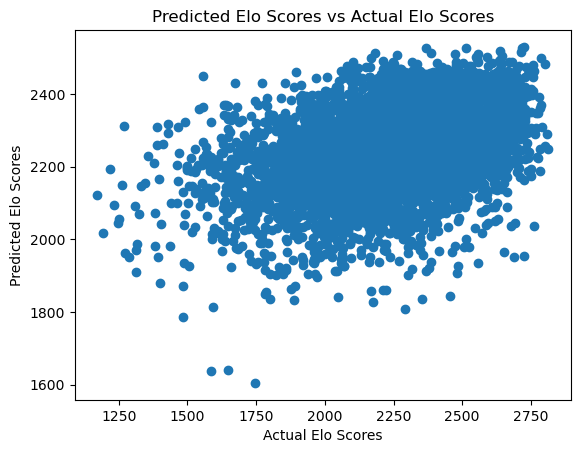

In [140]:
plt.scatter(w_y_validation, w_y_predicted)
plt.xlabel("Actual Elo Scores")
plt.ylabel("Predicted Elo Scores")
plt.title("Predicted Elo Scores vs Actual Elo Scores")
plt.show()

In [141]:
forest_regressor.fit(b_x_train, b_y_train)

c:\Users\acgra\anaconda3\envs\cs484\Lib\site-packages\sklearn\ensemble\_forest.py:435: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


RandomForestRegressor(n_estimators=200, random_state=0, verbose=1,
                      warm_start=True)

In [142]:
b_y_predicted = forest_regressor.predict(b_x_validation)
b_test_score = forest_regressor.score(b_x_validation, b_y_validation)
print("Test score:")
print(b_test_score)

b_mse = mean_squared_error(b_y_validation, b_y_predicted)
print("Mean standard error:")
print(b_mse)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Test score:
-0.0814927420495255
Mean standard error:
82549.82749301662


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


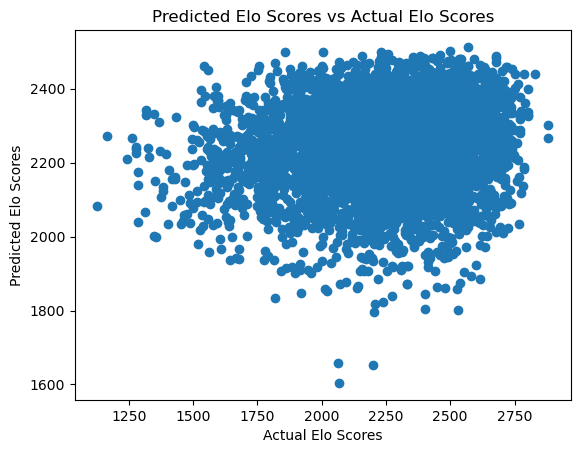

In [143]:
plt.scatter(b_y_validation, b_y_predicted)
plt.xlabel("Actual Elo Scores")
plt.ylabel("Predicted Elo Scores")
plt.title("Predicted Elo Scores vs Actual Elo Scores")
plt.show()